In [1]:
# ============= Time Series Analysis==========================================
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
import itertools
import matplotlib.dates as mdates
import matplotlib.pylab as plt
import matplotlib.backends.backend_pdf as bpdf


In [3]:
# read timeseries
file = './data/Shiraz.xlsx'
xl = pd.ExcelFile(file)
df = xl.parse('Sheet1')

df['date'] = df['year'].map(str)+'-'+df['month'].map(str)
    
tmpTS = df[['date', 'avgTemp']][:]
tmpTS['date'] = pd.to_datetime(tmpTS.date, format='%Y-%m')
tmpTS.set_index('date', inplace=True)
ts = tmpTS.T.squeeze()

ts


date
1951-01-01     6.6
1951-02-01     7.5
1951-03-01    10.5
1951-04-01    16.1
1951-05-01    21.6
              ... 
2017-08-01    28.7
2017-09-01    25.3
2017-10-01    20.5
2017-11-01    12.2
2017-12-01     8.8
Name: avgTemp, Length: 804, dtype: float64

In [4]:
from statsmodels.tsa.stattools import adfuller
def testStationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    #rolstd = pd.rolling_std(timeseries, window=12)
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
      
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                         '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

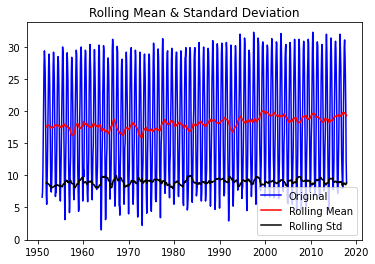

Results of Dickey-Fuller Test:
Test Statistic                  -3.091354
p-value                          0.027200
#Lags Used                      21.000000
Number of Observations Used    782.000000
Critical Value (1%)             -3.438740
Critical Value (5%)             -2.865243
Critical Value (10%)            -2.568742
dtype: float64


In [5]:
testStationarity(ts)

In [10]:
def greedy_algo_optimal_params(timeseries):
    '''
    This function is trying to find optimal parameter of ARIMA by greedy search
    ARIMA (p, d, q)(P, D, Q)s
    (p, d, q) are the non-seasonal parameters
    (P, D, Q) are applied to the seasonal component of the time series.
    s is the periodicity of the time series (4 for quarterly, 12 for yearly periods)
    '''
    
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)
    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    AIC_list = pd.DataFrame({}, columns=['param','param_seasonal','AIC'])
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(timeseries,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
    
                results = mod.fit()
    
                #print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
                temp = pd.DataFrame([[ param ,  param_seasonal , results.aic ]],\
                                    columns=['param','param_seasonal','AIC'])
                AIC_list = AIC_list.append( temp, ignore_index=True)  
                del temp
    
            except:
                continue
    
    
    m = np.amin(AIC_list['AIC'].values) # Find minimum value in AIC
    l = AIC_list['AIC'].tolist().index(m) # Find index number for lowest AIC
    Min_AIC_list = AIC_list.iloc[l,:]
    return Min_AIC_list
    

In [11]:
params = greedy_algo_optimal_params(ts)
params

param                 (1, 1, 1)
param_seasonal    (0, 1, 1, 12)
AIC                     2446.83
Name: 59, dtype: object

In [12]:
def ARIMAModel(parameters, timeseries):
    mod = sm.tsa.statespace.SARIMAX(timeseries,
                                order=parameters['param'],
                                seasonal_order=parameters['param_seasonal'],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()

    print("### Min_AIC_list ### \n{}".format(parameters))
 
    print(results.summary().tables[1])
  
    # model diagnostics to ensure that none of the assumptions made
    # by the model have been violated    
    fig = results.plot_diagnostics(figsize=(15, 10))
    #fig.set_facecolor('white')
    #fig.get_axis().set_facecolor('white')
   
    plt.savefig(r'./results/diagnostic.jpg', dpi=500)
    plt.show()
    
    return results


C:\Users\Neda\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Neda\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


### Min_AIC_list ### 
{'param': (1, 1, 1), 'param_seasonal': (0, 1, 1, 12)}
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2814      0.036      7.757      0.000       0.210       0.352
ma.L1         -1.0468      0.015    -72.101      0.000      -1.075      -1.018
ma.S.L12      -0.9684      0.018    -54.587      0.000      -1.003      -0.934
sigma2         1.1883      0.063     18.715      0.000       1.064       1.313


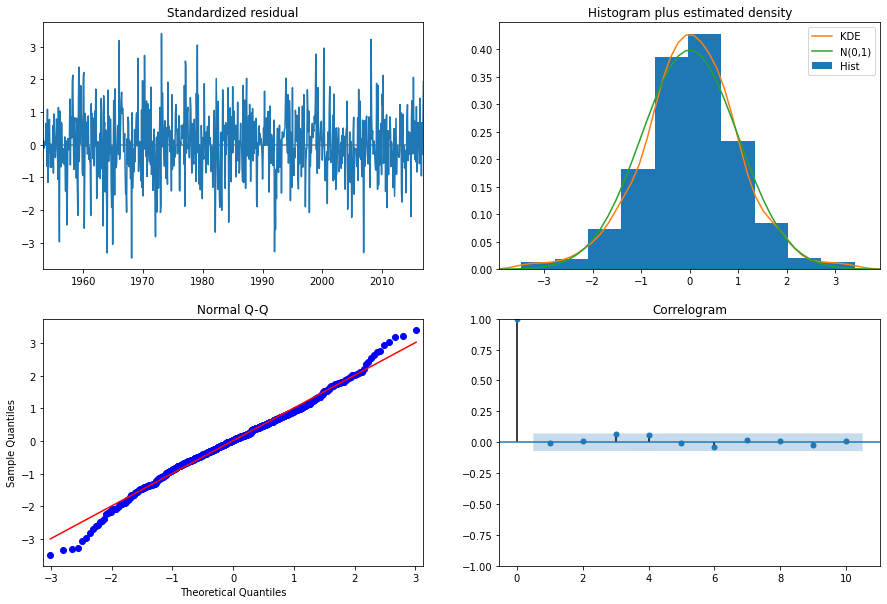

In [8]:
params = {'param':(1, 1, 1), 'param_seasonal':(0, 1, 1, 12)}
train = ts[:-12][:]
mod = ARIMAModel(params, train) 


In [9]:
def longForecast(mod, steps, timeseries, s_ind = 0):
    
    # Get forecast # steps ahead in future
    pred_uc = mod.get_forecast(steps=steps)
    
    # Get confidence intervals of forecasts
    pred_ci = pred_uc.conf_int()
    
    # plot forecast
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.set(xlabel="Date", ylabel="Temperature ($^\circ$C)",)

    ax.plot(timeseries[-(s_ind+steps):-steps], 'b:', label='Train', color='blue')
    ax.plot(timeseries[-steps:], 'r--', label='Test', color='red')
    ax.plot(pred_uc.predicted_mean, 'k-', label='Predicted', color='green')

    # Define the date format
    date_form = mdates.DateFormatter("%b %Y")
    ax.xaxis.set_major_formatter(date_form)
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right")
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    # Show the minor grid lines with very faint and almost transparent grey lines
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    
    plt.savefig(r'./images/predict_12m_sarima.jpg', dpi=500)
    plt.show()
    
    return pred_uc.predicted_mean


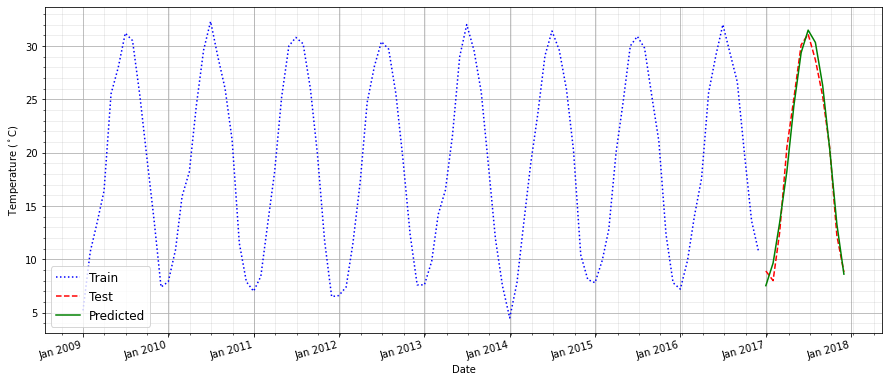

2017-01-01     7.524925
2017-02-01     9.645332
2017-03-01    13.425119
2017-04-01    18.252807
2017-05-01    24.411604
2017-06-01    29.369919
2017-07-01    31.482547
2017-08-01    30.325372
2017-09-01    26.319112
2017-10-01    20.380263
2017-11-01    13.272970
2017-12-01     8.604518
Freq: MS, dtype: float64

In [10]:
step = 12
pred = longForecast(mod, step, ts, 96)
pred